In [1]:
import os, time
from IPython import display

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tqdm.notebook import tqdm

In [2]:
#import neptune.new as neptune
#run = neptune.init(project='davidfu0826/GANPlayground')

In [3]:
PATH_TO_IMAGES = "../../Dataset/NewGazeData/*/*.jpg"
EPOCHS = 100
BATCH_SIZE = 256

#run["JIRA"] = "NPT-952"
#run["algorithm"] = "ConvNet"

params = {
    "dataset": PATH_TO_IMAGES,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "optimizer": "Adam"
}
#run["parameters"] = params

# Simple tf.data pipeline

In [4]:
#@tf.function
def read_files(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    return img

#@tf.function
def preprocess_input(img):
    img = tf.image.resize(img, (4, 4))
    img = (img - 127.5) / 127.5
    return img

In [5]:
list_ds = tf.data.Dataset.list_files(PATH_TO_IMAGES)
list_ds = list_ds.shuffle(buffer_size=len(list_ds), reshuffle_each_iteration=True)
list_ds = list_ds.map(read_files)
list_ds = list_ds.map(preprocess_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


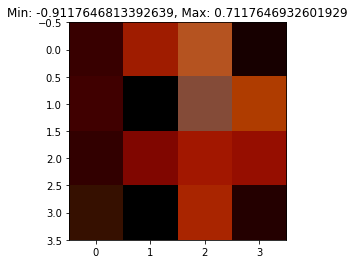

In [6]:
for img in list_ds.take(1):
    pass
plt.figure()
plt.imshow(img)

title = f"Min: {img.numpy().min()}, Max: {img.numpy().max()}"
plt.title(title)
plt.show()

In [7]:
list_ds = list_ds.batch(BATCH_SIZE)#tf.data.AUTOTUNE)
list_ds = list_ds.prefetch(buffer_size=-1)#tf.data.AUTOTUNE)

# Simple GAN

## Simple Generator

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256)  # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 4, 4, 3)

    #model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 4, 4, 128)
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    #model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 8, 8, 64)
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    #model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 16, 16, 3)

    return model

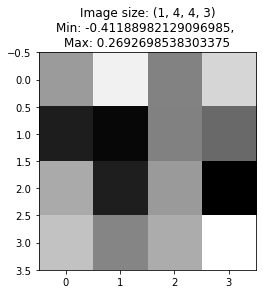

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.figure()
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
title = f"Image size: {generated_image.shape}\nMin: {generated_image.numpy().min()}, \nMax: {generated_image.numpy().max()}" 
plt.title(title)
plt.show()

## Simple discriminator

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[4, 4, 3], name="01_conv2d"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', name="02_conv2d"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, name="logits"))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00162383]], shape=(1, 1), dtype=float32)


# Loss and optimizer

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator loss

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Generator loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training loop

In [16]:
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [18]:
def train(dataset, epochs):
    history = {
        "gen_loss": list(),
        "disc_loss": list()
    }
    for epoch in range(epochs):
        start = time.time()

        gen_losses = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
        disc_losses = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)
        t_iter = tqdm(dataset)
        for image_batch in t_iter:
            gen_loss, disc_loss = train_step(image_batch)
            gen_losses(gen_loss)
            disc_losses(disc_loss)
            t_iter.set_description(f"G: {gen_losses.result()}, D: {disc_losses.result()}")

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)

        #run["train/gen_loss"].log(gen_losses.result())
        #run["train/disc_loss"].log(disc_losses.result())
        history["gen_loss"].append(gen_losses.result())
        history["disc_loss"].append(disc_losses.result())
        
        epoch_time = time.time()-start
        #run["train/epoch_time"].log(epoch_time)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, epoch_time))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)
    return history

In [19]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :] * 127.5 + 127.5)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

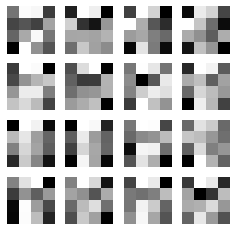

In [20]:
history = train(list_ds, params["epochs"])

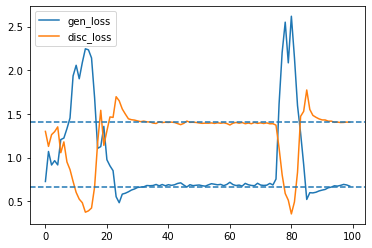

In [21]:
import numpy as np

plt.figure()
plt.plot(history["gen_loss"])
plt.plot(history["disc_loss"])
plt.legend(["gen_loss", "disc_loss"])
plt.axhline(np.mean(history["gen_loss"][-10:]), linestyle="--")
plt.axhline(np.mean(history["disc_loss"][-10:]), linestyle="--")
plt.show()

In [22]:
import glob
import imageio

img_glob_path = "*.png"
images = [imageio.imread(file_path) for file_path in glob.glob(img_glob_path)]
imageio.mimwrite('movie.gif', images, fps=10)